# RS Encode Scaling Results

In [252]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from palettable.cubehelix import Cubehelix
import seaborn as sns
import math

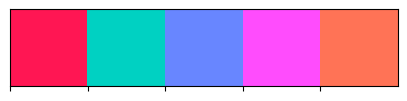

In [254]:
OUTPUT_DIR="rs_encode_scaling/"
colors = sns.cubehelix_palette(n_colors=10, start=5, rot=4, hue=3, light=0.4, dark=.8)
colors = np.array(colors)[[0,3,4,5,6]]
sns.palplot(colors)

In [401]:
def save_fig(file_name, figure, output_dir):
    figure.patch.set_facecolor("white")
    figure.savefig(output_dir + file_name, bbox_inches="tight")

# New results

In [339]:
def read_in_results(num_instances, platform, results_root):
    base_result_path = f"{results_root}/{platform}_{num_instances}"
    dfs = []
    
    for i in range(0, num_instances):
        if platform == "cpu":
            base_port = 50000
            curr_df = pd.read_csv(f"{base_result_path}/server_{base_port+i}.out")
            curr_df["timestamp_us"] = curr_df["timestamp_ms"]*1000
            curr_df.drop("timestamp_ms", axis=1, inplace=True)
            curr_df = trim_to_time(curr_df, 0.3)
        else:
            base_port = 60000
            curr_df = pd.read_csv(f"{base_result_path}/bw_log_{base_port + i}.csv")
            curr_df = curr_df.loc[curr_df["reqs_done"] != 0]
            curr_df["timestamp_us"] = (curr_df["timestamp"] * 4) * (10 ** -3)
            curr_df.drop("timestamp", axis=1, inplace=True)
            curr_df = trim_to_time(curr_df, 0.3)
            
        curr_df["instance_index"] = i
        dfs.append(curr_df)

    return pd.concat(dfs)

In [340]:
def trim_to_time(input_df, warmup_fraction):
    input_df.sort_values("timestamp_us", inplace=True)
    first = input_df.iloc[0]
    last = input_df.iloc[-1]
    timespan = last["timestamp_us"] - first["timestamp_us"]
    warmup = timespan/3
    start = int(first["timestamp_us"] + warmup)
    end = start + warmup
    
    result = input_df.loc[(input_df["timestamp_us"] >= int(start)) & (input_df["timestamp_us"] < int(end))]
    return result

## FPGA Data Parsing

In [350]:

def calc_fpga_bws(input_df):
    instances = input_df.groupby("instance_index")
    return instances

In [358]:
fpga_dfs = []
for i in range(1, 5):
    fpga_df = read_in_results(i, "fpga", "rs_encode_scaling/results/")
    fpga_df = calc_bws(fpga_df)
    fpga_dfs.append(fpga_df)

In [514]:
fpga_dfs_6k = []
for i in range(1, 5):
    fpga_df = read_in_results(i, "fpga", "rs_encode_scaling/results_6k/")
    fpga_df = calc_bws(fpga_df)
    fpga_dfs_6k.append(fpga_df)

## CPU Data Parsing

In [357]:
cpu_dfs = []
for i in range(1, 5):
    cpu_df = read_in_results(i, "cpu", "rs_encode_scaling/results/")
    cpu_df = calc_bws(cpu_df)
    cpu_dfs.append(cpu_df)

In [356]:
def calc_bws(input_df):
    instances = input_df.groupby("instance_index")
    firsts = instances.min("timestamp_us")
    #firsts.rename(columns={"timestamp_us", "timestamp_us_min"}, inplace=True)
    maxes = instances.max("timestamp_us")
    #maxes.rename(columns={"timestamp_us", "timestamp_us_max"}, inplace=True)
    joined = pd.merge(firsts, maxes, on="instance_index", suffixes=["_min", "_max"])
    
    joined["elapsed_s"] = (joined["timestamp_us_max"] - joined["timestamp_us_min"]) * (10 ** -6)
    joined["bits_per_sec"] = ((joined["bytes_sent_max"] - joined["bytes_sent_min"])*8)/joined["elapsed_s"]
    joined["reqs_per_sec"] = (joined["reqs_done_max"] - joined["reqs_done_min"])/joined["elapsed_s"]
    joined["total_reqs"] = joined["reqs_done_max"] - joined["reqs_done_min"]
    joined.reset_index(inplace=True)

    return joined

In [517]:
cpu_dfs_6k = []
for i in range(1, 5):
    cpu_df = read_in_results(i, "cpu", "rs_encode_scaling/results_6k")
    cpu_df = calc_bws(cpu_df)
    cpu_dfs_6k.append(cpu_df)

## Make BW graph

In [365]:
def merge_cpu_fpga(total_instances, cpu, fpga):
    dfs = []
    for i in range(0, total_instances):
        cpu_df = cpu[i]
        fpga_df = fpga[i]
        selected_cpu_cols = cpu_df[["bits_per_sec", "reqs_per_sec", "total_reqs"]]
        cpu_vals = selected_cpu_cols.sum()
        selected_fpga_cols = fpga_df[["bits_per_sec", "reqs_per_sec", "total_reqs"]]
        cpu_vals["platform"] = "cpu"
        fpga_vals = selected_fpga_cols.sum()
        fpga_vals["platform"] = "fpga"
        
        cpu_vals["num_instances"] = cpu_df["instance_index"].nunique()
        fpga_vals["num_instances"] = fpga_df["instance_index"].nunique()
        cpu_vals["gbits_per_sec"] = cpu_vals["bits_per_sec"]/(10 ** 9)
        fpga_vals["gbits_per_sec"] = fpga_vals["bits_per_sec"]/(10 ** 9)
        
        
        dfs.append(cpu_vals)
        dfs.append(fpga_vals)
        
    return pd.DataFrame(dfs)
        

In [530]:
merged_df = merge_cpu_fpga(4, cpu_dfs, fpga_dfs)

In [531]:
merged_df_6k = merge_cpu_fpga(4, cpu_dfs_6k, fpga_dfs_6k)

In [532]:
def create_bw_graph(input_dataframe, platforms, markers, colors):
    fig, ax = plt.subplots()

    subsets = []
    legend_labels = []

    for platform in platforms:
        subset = input_dataframe.loc[input_dataframe.platform.eq(platform)]
        subsets.append(subset)
        legend_labels.append(platform)

    for i in range(0, len(subsets)):
        subsets[i].plot(x="num_instances", y="gbits_per_sec", ax=ax, marker=markers[i], color=[colors[i]], label=platforms[i])

    x_ticks = input_dataframe["num_instances"].unique()
    ax.set_xlabel("Application Instances", fontsize=16)
    ax.set_ylabel("Goodput (Gbps)", fontsize=16)
    plt.xticks(x_ticks, fontsize=14)
    plt.yticks(fontsize=14)
    plt.draw()

    return fig, ax


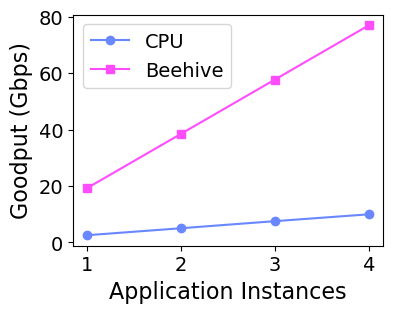

In [533]:
fig, ax = create_bw_graph(merged_df, ["cpu","fpga"], ["o", "s", "*", "v"], colors[2:])
ax.legend(["CPU", "Beehive"], fontsize=14)


fig.set_size_inches(4, 3)
save_fig("rs_encoding_scaling.pdf", fig, OUTPUT_DIR)

## Get energy

In [551]:
def read_in_energy_df(result_dir, num_instances, cpu_dfs):
    energy_df = []
    for i in range(1, num_instances + 1):        
        fpga_energy = pd.read_csv(f"{result_dir}/fpga_{i}/energy_fpga.out")
        fpga_energy["timestamp_us"] = fpga_energy["timestamp"] * (10**6)
        fpga_energy.drop("timestamp", axis=1, inplace=True)
        fpga_energy = trim_to_time(fpga_energy, 0.3)
        first_energy = fpga_energy.iloc[0]["energy_joule"]
        last_energy = fpga_energy.iloc[-1]["energy_joule"]

        cpu_energy = pd.read_csv(f"{result_dir}/cpu_{i}/energy_cpu.out")
        cpu_energy["timestamp_us"] = cpu_energy["timestamp"] * (10**6)
        cpu_energy.drop("timestamp", axis=1, inplace=True)
        cpu_df = cpu_dfs[i-1]
        cpu_time_min = cpu_df["timestamp_us_min"].max()
        cpu_time_max = cpu_df["timestamp_us_max"].min()
        cpu_energy_trimmed = cpu_energy.loc[(cpu_energy["timestamp_us"] >= cpu_time_min) & (cpu_energy["timestamp_us"] < cpu_time_max)]
        first_cpu_energy = cpu_energy_trimmed.iloc[0]["energy_joule"]
        last_cpu_energy = cpu_energy_trimmed.iloc[-1]["energy_joule"]


        energy_df.append({"energy_joule": last_energy - first_energy, "num_instances": i, "platform": "fpga"})
        energy_df.append({"energy_joule": last_cpu_energy - first_cpu_energy, "num_instances": i, "platform": "cpu"})


    energy_df = pd.DataFrame(energy_df)
    return energy_df
    

In [552]:
energy_df = read_in_energy_df("rs_encode_scaling/results/", 4, cpu_dfs)

In [553]:
energy_df_6k = read_in_energy_df("rs_encode_scaling/results_6k/", 4, cpu_dfs_6k)

In [536]:
merged_energy = pd.merge(energy_df, merged_df, on=["num_instances", "platform"])
merged_energy["joule_per_op"] = merged_energy["energy_joule"]/merged_energy["total_reqs"]
merged_energy["mj_per_op"] = merged_energy["joule_per_op"] * 1000
graph_energy = merged_energy[["mj_per_op", "platform", "num_instances"]]

In [554]:
merged_energy_6k = pd.merge(energy_df_6k, merged_df_6k, on=["num_instances", "platform"])
merged_energy_6k["joule_per_op"] = merged_energy_6k["energy_joule"]/merged_energy_6k["total_reqs"]
merged_energy_6k["mj_per_op"] = merged_energy_6k["joule_per_op"] * 1000
graph_energy_6k = merged_energy_6k[["mj_per_op", "platform", "num_instances"]]

In [555]:
graph_energy_6k

,mj_per_op,platform,num_instances
0,0.050600,fpga,1
1,1.466940,cpu,1
2,0.027547,fpga,2
3,0.630156,cpu,2
4,0.019753,fpga,3
5,0.464434,cpu,3
6,0.017251,fpga,4
7,0.402629,cpu,4


In [537]:
def create_energy_bar(input_pivot):
    fig, ax = plt.subplots()
    input_pivot.plot.bar(ax=ax, color=colors[2:], width=0.9)
    for container in ax.containers:
        ax.bar_label(container,fmt="%.2f", fontsize=14)
    ax.legend(["CPU", "Beehive"], fontsize=14)
    ax.set_ylabel("Energy (mj/op)", fontsize=16)
    ax.set_xlabel("# of application instances", fontsize=16)
    ax.set_xticks(ax.get_xticks(), labels=ax.get_xticklabels(), fontsize=12)
    ax.set_yticks(ax.get_yticks(), labels=ax.get_yticklabels(), fontsize=12)
    ax.get_legend().set_title("Platform")
    ax.get_legend().get_title().set_fontsize(14)
    ax.set_ylim([0, 1.3])
    
    return fig, ax


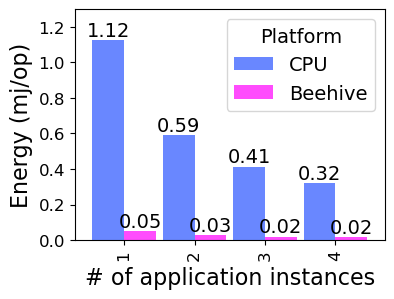

In [538]:
bars_pivot = graph_energy.pivot(index="num_instances", columns="platform", values="mj_per_op")
fig, ax = create_energy_bar(bars_pivot)
fig.set_size_inches(4, 3)
save_fig("rs_encoding_energy.pdf", fig, OUTPUT_DIR)

In [570]:
pivot_energy_6k = graph_energy_6k.pivot(index="num_instances", columns="platform", values="mj_per_op")
energy_speedup_6k = pivot_energy_6k["cpu"]/pivot_energy_6k["fpga"]
pivot_energy_6k

platform,cpu,fpga
num_instances,,
1,1.466940,0.050600
2,0.630156,0.027547
3,0.464434,0.019753
4,0.402629,0.017251


In [564]:
pivot_6k = merged_df_6k.pivot(index='num_instances', columns='platform', values='gbits_per_sec')
pivot_6k
speedup = pivot_6k["fpga"]/pivot_6k["cpu"]
speedup

num_instances
1    10.223020
2     8.343487
3     8.711480
4     8.890414
dtype: float64

In [565]:
pivot_

platform,cpu,fpga
num_instances,,
1,2.635950,26.947367
2,6.459497,53.894734
3,9.279952,80.842110
4,11.145444,99.087610


In [539]:
pivot_df = merged_df.pivot(index='num_instances', columns='platform', values='gbits_per_sec')
speedup = pivot_df["fpga"]/pivot_df["cpu"]
speedup

num_instances
1    7.615243
2    7.687163
3    7.680940
4    7.739064
dtype: float64

In [575]:
0.403/0.017

23.705882352941178

# Old results

In [4]:
def process_raw_logs(input_dataframe):
    tmp = input_dataframe.assign(avg_agg_gbps=lambda row: row["avg_agg_bps"]/(10**9))
    return tmp

In [5]:
def save_fig(file_name, figure, output_dir):
    figure.patch.set_facecolor("white")
    figure.savefig(output_dir + file_name, bbox_inches="tight")

In [6]:
rs_encode_data = pd.read_csv("rs_encode_scaling.csv")
rs_encode_data_processed = process_raw_logs(rs_encode_data)

In [7]:
rs_encode_data_processed
rs_encode_data_processed["avg_agg_reqs_per_sec"]/(10**6)

0    0.469908
1    0.939802
2    1.409701
3    1.731991
Name: avg_agg_reqs_per_sec, dtype: float64

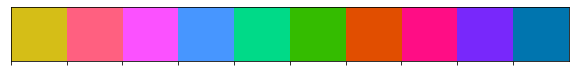

In [40]:
scatter_colors = sns.cubehelix_palette(n_colors=10, start=2, hue=3, rot=4, light=0.3, dark=0.7, reverse=True)
sns.palplot(scatter_colors)

selected_colors=[scatter_colors[8], scatter_colors[3], scatter_colors[0], scatter_colors[6]]

In [41]:
def create_rs_scaling_bars(dataframe, colors):
    fig, ax = plt.subplots()
    sns.barplot(x="num_apps", y="avg_agg_gbps", data=dataframe, palette=colors)
    
    ax.set_xlabel("Reed-Solomon Encoder Tiles", fontsize=14)
    ax.set_ylabel("Aggregate Goodput (Gbps)", fontsize=14)

    return fig,ax

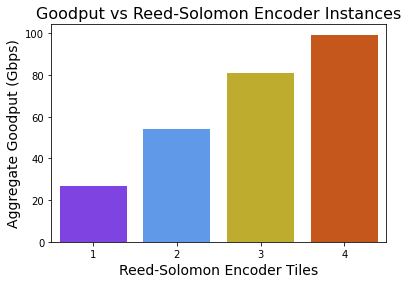

In [42]:
fig, ax = create_rs_scaling_bars(rs_encode_data_processed, selected_colors)
ax.set_title("Goodput vs Reed-Solomon Encoder Instances", fontsize=16)
save_fig("bw_rs_encoder_vs_num_tiles.pdf", fig, OUTPUT_DIR)
